In [1]:
import os
import glob
import warnings
import sqlite3
import re

In [2]:
import numpy as np
import pandas as pd

In [3]:
from astropy.table import Table

In [4]:
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.cameraGeom as cameraGeom

In [5]:
from lsst.daf.persistence import Butler

In [6]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## With the tract mapping DB

In [10]:
repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1' 
b = Butler(repo)
skymap = b.get('deepCoadd_skyMap')

In [27]:
ramin = 56
ramax = 58
decmin = -32
decmax = -31

In [28]:
# creating a rectangle of 2 sq. degree for tract/patch search
radec_NE = afwGeom.SpherePoint(ramax, decmax, afwGeom.degrees)
radec_SE = afwGeom.SpherePoint(ramax, decmin, afwGeom.degrees)
radec_SW = afwGeom.SpherePoint(ramin, decmin, afwGeom.degrees)
radec_NW = afwGeom.SpherePoint(ramin, decmax, afwGeom.degrees)
rect = [radec_NE, radec_NW, radec_SW, radec_SE]

In [29]:
tpatches = skymap.findTractPatchList(rect)

In [30]:
# to figure the visits on this patches we need the DB  
# this will help us dtermine seeing and time cuts for coadds
database = repo+'/tracts_mapping.sqlite3'
query_tmpl = "select DISTINCT(visit), filter from overlaps WHERE tract={} and patch={} order by visit"
conn = sqlite3.connect(database)
c = conn.cursor()

In [31]:
full_visits = []
# check the tracts+patch, print their names
for atract in tpatches:
    print(atract[0])  # prints the number of the tract
    thepatches = atract[1]  # next things on list are the patches
    tract_visits = []
    for apatch in thepatches:
        print(apatch)
        # Now we have the list of tract+patch 
        # let's find the visit list
        patchx, patchy = apatch.getIndex()
        strpatch = "'"+str((int(patchx), int(patchy)))+"'"
        query = query_tmpl.format(atract[0].getId(), strpatch)
        visitab = pd.read_sql_query(query, conn)
        full_visits.append(visitab)
        tract_visits.append(visitab)

TractInfo(id=4640)
PatchInfo(index=(3, 0))
PatchInfo(index=(3, 1))
PatchInfo(index=(4, 0))
PatchInfo(index=(4, 1))
PatchInfo(index=(5, 0))
PatchInfo(index=(5, 1))
PatchInfo(index=(6, 0))
PatchInfo(index=(6, 1))
TractInfo(id=4639)
PatchInfo(index=(0, 0))
PatchInfo(index=(0, 1))
PatchInfo(index=(1, 0))
PatchInfo(index=(1, 1))
PatchInfo(index=(2, 0))
PatchInfo(index=(2, 1))
PatchInfo(index=(3, 0))
PatchInfo(index=(3, 1))
PatchInfo(index=(4, 0))
PatchInfo(index=(4, 1))
TractInfo(id=4431)
PatchInfo(index=(0, 3))
PatchInfo(index=(0, 4))
PatchInfo(index=(0, 5))
PatchInfo(index=(0, 6))
PatchInfo(index=(1, 3))
PatchInfo(index=(1, 4))
PatchInfo(index=(1, 5))
PatchInfo(index=(1, 6))
PatchInfo(index=(2, 3))
PatchInfo(index=(2, 4))
PatchInfo(index=(2, 5))
PatchInfo(index=(2, 6))
TractInfo(id=4432)
PatchInfo(index=(1, 3))
PatchInfo(index=(1, 4))
PatchInfo(index=(1, 5))
PatchInfo(index=(1, 6))
PatchInfo(index=(2, 3))
PatchInfo(index=(2, 4))
PatchInfo(index=(2, 5))
PatchInfo(index=(2, 6))
PatchInfo(in

In [32]:
visitab_tractmapping = pd.concat(full_visits).drop_duplicates('visit').reset_index(drop=True)
print(len(visitab_tractmapping))

563


## With the minion DB

In [39]:
from collections import OrderedDict as Odict
from astropy import time

from lsst.sims.utils import angularSeparation
from lsst.sims.utils import getRotSkyPos
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator

In [34]:
# visits database
dbname = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
ObsMetaData = ObservationMetaDataGenerator(database=dbname)

In [54]:
t0=59215; tm=61406

In [37]:
res = ObsMetaData.getObservationMetaData(boundLength=2, boundType='circle', 
                                    fieldRA=(ramin-3, ramax+3), 
                                    fieldDec=(decmin-3, decmax+3), 
                                    expMJD=(t0, tm))

In [40]:
parsed = [Odict(obsmd.summary['OpsimMetaData']) for obsmd in res]
for obsmd, summ in zip(res, parsed):
    ditherRa = np.rad2deg(summ['descDitheredRA'])
    ditherDec = np.rad2deg(summ['descDitheredDec'])
    ditherRot = np.rad2deg(summ['descDitheredRotTelPos'])
    summ['descDitheredRotSkyPos'] =  getRotSkyPos(ditherRa, ditherDec, 
                                                    obsmd, ditherRot)

In [41]:
df = pd.DataFrame(parsed)

In [42]:
len(df)

2481

In [43]:
df = df[df['filter'].isin(('g', 'r', 'i', 'z'))]

In [44]:
len(df)

1812

In [45]:
X = df[['obsHistID', 'filter', 'FWHMeff', 'descDitheredRA', 
        'descDitheredDec', 'descDitheredRotTelPos', 'airmass', 
        'fiveSigmaDepth', 'expMJD', 'descDitheredRotSkyPos',
        'fieldRA', 'fieldDec', 'rotSkyPos', 'rotTelPos']].copy()
X.descDitheredRA = np.rad2deg(X.descDitheredRA)
X.descDitheredDec = np.rad2deg(X.descDitheredDec)
X.descDitheredRotTelPos = np.rad2deg(X.descDitheredRotTelPos)
#X.descDitheredRotSkyPos = np.rad2deg(X.descDitheredRotSkyPos) already in deg

In [46]:
X.fieldRA = np.rad2deg(X.fieldRA)
X.fieldDec = np.rad2deg(X.fieldDec)
X.rotTelPos = np.rad2deg(X.rotTelPos)
X.rotSkyPos = np.rad2deg(X.rotSkyPos)

In [51]:
X['d1'] = angularSeparation(ramin, decmax, 
    X.descDitheredRA.values, X.descDitheredDec.values)
X['d2'] = angularSeparation(ramin, decmin, 
    X.descDitheredRA.values, X.descDitheredDec.values)
X['d3'] = angularSeparation(ramax, decmax, 
    X.descDitheredRA.values, X.descDitheredDec.values)
X['d4'] = angularSeparation(ramax, decmin, 
    X.descDitheredRA.values, X.descDitheredDec.values)
visitab_minion = X.query('d1 < 1.75 | d2 < 1.75 | d3 < 1.75 |d4 < 1.75')

In [52]:
len(visitab_minion)

811

In [57]:
visitab = visitab_minion[visitab_minion['obsHistID']<np.max(visitab_tractmapping['visit'])]
len(visitab)

446

In [60]:
diaSrc_store = pd.HDFStore('/global/homes/b/bos0109/run2_diaproc/results/diaSrc_secrun_fulltables_v4.h5')
diaSrc_store.open()
diasrc_tab = diaSrc_store['full_table']
diaSrc_store.close()

In [62]:
len(np.unique(diasrc_tab['visit_n']))

413

Text(0.5, 0, 'Visit N')

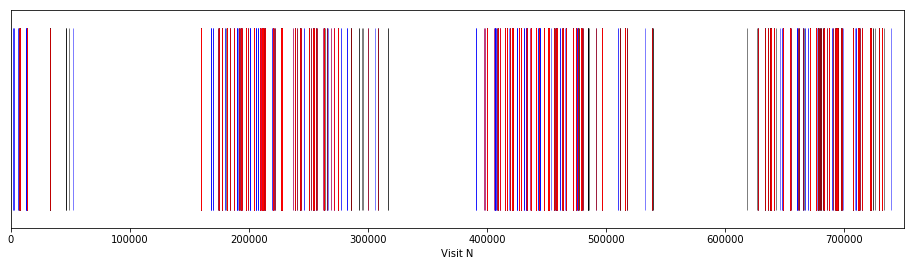

In [61]:
plt.figure(figsize=(16,4))
plt.vlines(x=np.unique(visitab_tractmapping['visit']), ymin=0, ymax=1, colors='blue', lw=0.5)
plt.vlines(x=np.unique(visitab['obsHistID']), ymin=0, ymax=1, colors='black', lw=0.5)
plt.vlines(x=np.unique(diasrc_tab['visit_n']), ymin=0, ymax=1, colors='red', lw=0.5)
plt.xlim(-10, 750_000)
plt.yticks([-1, 2])
plt.ylim(-0.1, 1.1)
plt.xlabel('Visit N')